In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.utils import py_random_state
from networkx.generators.random_graphs import _random_subset
import numpy as np
import random

import time
import os

Creazione del grafo con l'algoritmo di Barabasi-Albert

In [2]:
N = 50
M = 3
G = nx.barabasi_albert_graph(N, M)

Rappresentazione del grafico

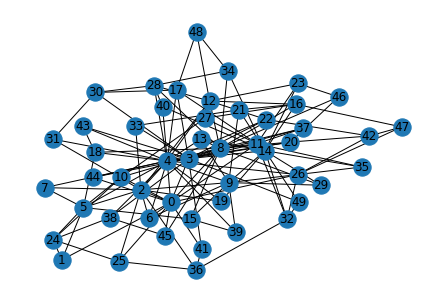

In [3]:
nx.draw(G, with_labels=True)    
plt.show()

Estrazione della matrice di adiacenza A

In [4]:
adjacency = list(G.adjacency())
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)] 
    for c in b : 
        A[a][c] = 1

Estrazione della matrice di stocastica P e calcolo dei suoi autovalori e autovettori

In [5]:
P = []
for a, b in adjacency :
    P += [[0]*len(adjacency)]
    for c in b: 
        P[a][c] = 1./G.degree[a]

In [6]:
matrixP = np.array(P)
autovaloriP, autovettoriP = np.linalg.eig(np.transpose(matrixP))
autovettoriP = np.transpose(autovettoriP)
pS = autovettoriP[0]
if pS[0] < 0:
    pS = -pS
#np.dot(np.transpose(matrix),autovettori[0])

In [7]:
autovaloriP

array([ 1.        ,  0.69644089,  0.60864135,  0.59571547,  0.55867547,
       -0.64627086,  0.52605544, -0.61672477, -0.60075689, -0.57233446,
       -0.54642854, -0.52467328, -0.52750111,  0.47578064, -0.45962699,
       -0.42913032,  0.42105588,  0.41188228,  0.38098942,  0.37404489,
       -0.39562652, -0.37805546, -0.35710141, -0.3373688 ,  0.32846909,
        0.30356115,  0.28474495, -0.30149163, -0.27937886, -0.26568682,
       -0.23424162, -0.1951252 ,  0.22304455,  0.21667902,  0.1816978 ,
        0.17870378,  0.15179623,  0.12463581, -0.15261346, -0.13268038,
       -0.12312168,  0.09579737,  0.06421418,  0.05287552,  0.02300914,
        0.00286538, -0.02331751, -0.07620799, -0.05896603, -0.04694508])

Definizione della matrice laplaciana L e calcolo dei suoi autovettori e autovalori

In [8]:
matrixL = np.identity(N) - matrixP

In [9]:
autovaloriL, autovettoriL = np.linalg.eig(np.transpose(matrixL))
autovettoriL = np.transpose(autovettoriL)
pS_L = autovettoriL[0]
if pS_L[0] < 0:
    pS_L = -pS_L

In [10]:
autovaloriL

array([-1.85623890e-17,  3.03559109e-01,  3.91358651e-01,  4.04284528e-01,
        4.41324528e-01,  1.64627086e+00,  4.73944561e-01,  1.61672477e+00,
        1.60075689e+00,  1.57233446e+00,  1.54642854e+00,  1.52467328e+00,
        1.52750111e+00,  5.24219364e-01,  1.45962699e+00,  5.78944125e-01,
        5.88117724e-01,  6.19010584e-01,  6.25955113e-01,  1.42913032e+00,
        1.39562652e+00,  1.37805546e+00,  1.35710141e+00,  1.33736880e+00,
        6.71530912e-01,  6.96438848e-01,  7.15255051e-01,  1.30149163e+00,
        1.27937886e+00,  1.26568682e+00,  1.23424162e+00,  1.19512520e+00,
        7.76955446e-01,  7.83320977e-01,  8.18302198e-01,  8.21296217e-01,
        8.48203770e-01,  8.75364187e-01,  1.15261346e+00,  9.04202632e-01,
        1.13268038e+00,  1.12312168e+00,  9.35785823e-01,  9.47124483e-01,
        9.76990862e-01,  9.97134618e-01,  1.02331751e+00,  1.07620799e+00,
        1.05896603e+00,  1.04694508e+00])

La distribuzione stazionaria e il valore di Fiedler estratto dalle due matrici L e P coincidono fino alla 13-esima cifra decimale

In [11]:
i = 13
np.round(pS, i) == np.round(pS_L, i)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [12]:
round(1-max(autovaloriP[1:]), i) == round(min(autovaloriL[1:]), i)

True

Definizione del valore valore di Fiedler e della distribuzione stazionaria approssimate

In [13]:
FiedlerValue = round(min(autovaloriL[1:]), i)

In [14]:
pS = np.round(pS, i)

Assegnazione degli individui ai nodi per l'evoluzione della dinamica. L'assegnazione degli individui è fatta secondo una distribuzione uniforme.

In [15]:
walker_per_node = 15

In [16]:
seed = np.random.RandomState()
def dynamic_evolution(G, history = []):
    evolution = [0] * len(G.nodes)
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neighbours = list(G[n])
            new_node = _random_subset(neighbours, 1, seed).pop()
            evolution[new_node] += 1
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[n]
    history += [evolution]

In [17]:
history = [[], [], []]
for h in range(len(history)):
    history[h] = [[walker_per_node] * len(G.nodes)]

# history[0] = [[walker_per_node] * len(G.nodes)]
# history[1] = [[walker_per_node] * len(G.nodes)]
# history[2] = [[walker_per_node] * len(G.nodes)]
time_steps = int(5e4)

In [18]:
t0 = time.time()

for h in range(len(history)):
    for n in G.nodes:
        G.nodes[n]['N_i'] = walker_per_node
    
    for t in range(time_steps):
        dynamic_evolution(G, history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 3 minutes and 51.78664565086365 seconds


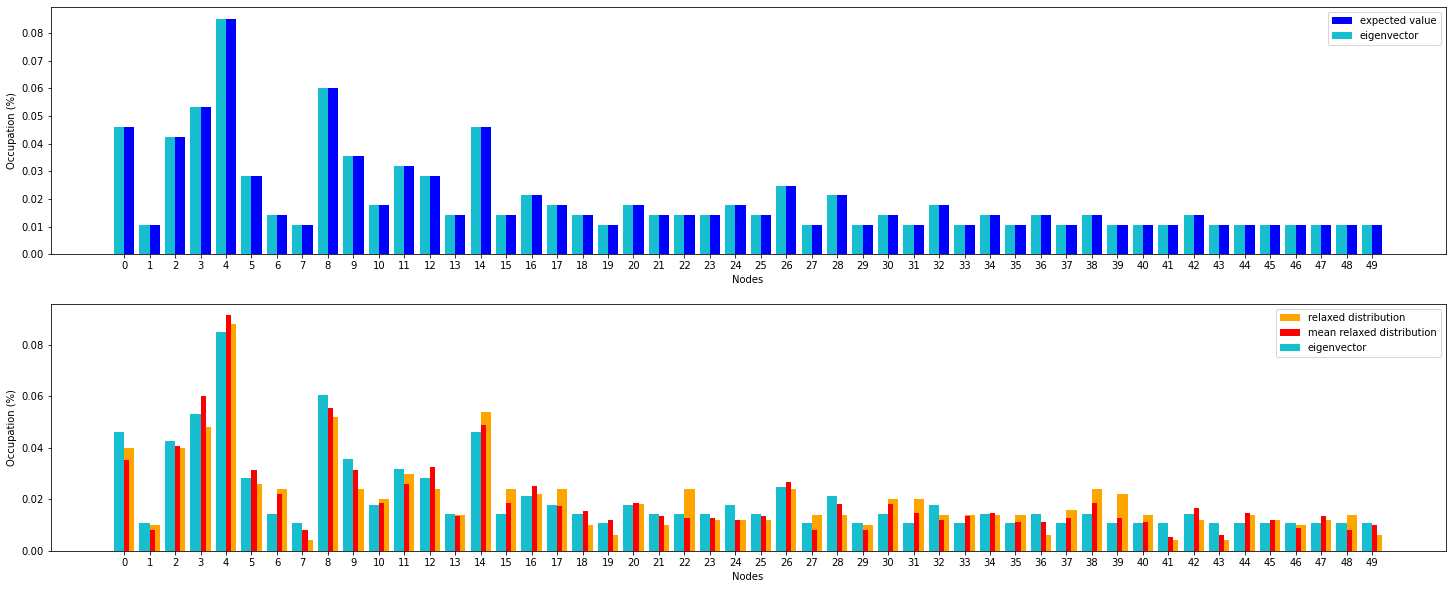

In [19]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(0.5*N, 10))

pSNorm = [d for n, d in G.degree()]
pSNorm = [h/sum(pSNorm) for h in pSNorm]

ax[0].bar(G.nodes, [h/sum(pSNorm) for h in pSNorm], width=0.4, align='edge', color='blue', label="expected value")
ax[0].bar(G.nodes, [h/sum(pS) for h in pS], width=-0.4, align='edge', color='tab:cyan', label="eigenvector")

ax[1].bar(G.nodes, [h/sum(history[0][-1]) for h in history[0][-1]], width=0.4, 
          align='edge', color='orange', label='relaxed distribution')
ax[1].bar(G.nodes, [(h1+h2+h3)/(sum(history[0][-1] + history[1][-1] + history[2][-1])) 
                    for h1, h2, h3 in zip(history[0][-1], history[1][-1], history[2][-1])],
          width=0.2, align='edge', color='red', label='mean relaxed distribution')
ax[1].bar(G.nodes, [h/sum(pS) for h in pS], width=-0.4, align='edge', color='tab:cyan', label="eigenvector")

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlabel("Nodes")
    ax[i].set_ylabel("Occupation (%)")
    ax[i].set_xticks(np.arange(0, N, 1))
#     ax[i].grid(True)


plt.show()

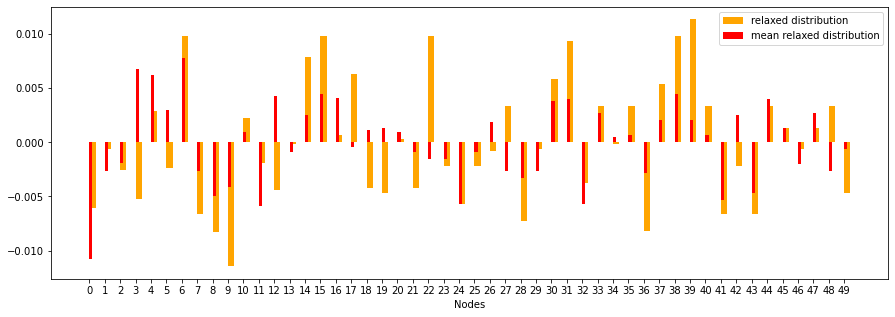

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.3*N, 5))

ax.bar(G.nodes, [h/sum(history[0][-1]) - k for h, k in zip(history[0][-1], pSNorm)], width=0.4, 
          align='edge', color='orange', label='relaxed distribution')
ax.bar(G.nodes, [(h1+h2+h3)/(sum(history[0][-1]) + sum(history[1][-1]) + sum(history[2][-1])) - k
                    for h1, h2, h3, k in zip(history[0][-1], history[1][-1], history[2][-1], pSNorm)],
          width=0.2, align='edge', color='red', label='mean relaxed distribution')

ax.legend()
ax.set_xlabel("Nodes")
# ax.set_ylabel("Occupation (%)")
ax.set_xticks(np.arange(0, N, 1))
# ax[i].grid(True)

plt.show()

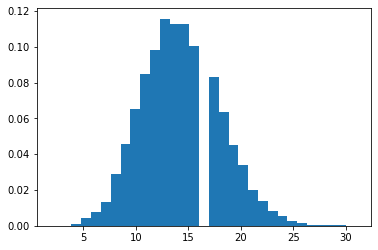

In [21]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)

node = 5
p_node = [h[node] for h in history[0]]
plt.hist(p_node, bins = max(p_node), density = True)

plt.show()

In [ ]:
print(sum(p_node)/time_steps)
print(pSNorm[node]*N*walker_per_node)